In [36]:
# !pip install --upgrade ipykernel

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [38]:
df = pd.read_csv('../data/ExtractedTweets.csv')
df

Party         Handle  \
0        Democrat  RepDarrenSoto   
1        Democrat  RepDarrenSoto   
2        Democrat  RepDarrenSoto   
3        Democrat  RepDarrenSoto   
4        Democrat  RepDarrenSoto   
...           ...            ...   
86455  Republican    RepTomPrice   
86456  Republican    RepTomPrice   
86457  Republican    RepTomPrice   
86458  Republican    RepTomPrice   
86459  Republican    RepTomPrice   

                                                   Tweet  
0      Today, Senate Dems vote to #SaveTheInternet. P...  
1      RT @WinterHavenSun: Winter Haven resident / Al...  
2      RT @NBCLatino: .@RepDarrenSoto noted that Hurr...  
3      RT @NALCABPolicy: Meeting with @RepDarrenSoto ...  
4      RT @Vegalteno: Hurricane season starts on June...  
...                                                  ...  
86455  Check out my op-ed on need for End Executive O...  
86456  Yesterday, Betty &amp; I had a great time lear...  
86457  We are forever grateful for the service and sa...  
86458  Happy first day of school @CobbSchools! #CobbB...  
86459  #Zika fears realized in Florida. House GOP act...  

[86460 rows x 3 columns]

In [39]:
df['Tweet'].isnull().sum()

0

# Creating 'tokens' column from the Tweets

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

def custom_tokenizer(string):
    tokenizer= CountVectorizer(stop_words='english').build_tokenizer()
    tokens = tokenizer(string.lower())
#     lemmitized_tokens = [...]
#     stemmed_tokens = [...]
    return tokens

In [41]:
df['tokens'] = df['Tweet'].map(custom_tokenizer)

In [42]:
# https://towardsdatascience.com/try-texthero-the-absolute-simplest-way-to-clean-and-analyze-text-in-pandas-6db86ed14272
# !pip install texthero
import texthero as hero

In [43]:
df['tokens'] = hero.clean(df['tokens'])

In [44]:
def remove_words(lst):
    lst = lst.replace('https', '')
    lst = lst.replace('co', '')
    lst = lst.replace('rt', '')
    lst = lst.replace('amp', '')
    return lst

In [45]:
df['tokens'] = df['tokens'].map(remove_words)
df.head()

Party         Handle                                              Tweet  \
0  Democrat  RepDarrenSoto  Today, Senate Dems vote to #SaveTheInternet. P...   
1  Democrat  RepDarrenSoto  RT @WinterHavenSun: Winter Haven resident / Al...   
2  Democrat  RepDarrenSoto  RT @NBCLatino: .@RepDarrenSoto noted that Hurr...   
3  Democrat  RepDarrenSoto  RT @NALCABPolicy: Meeting with @RepDarrenSoto ...   
4  Democrat  RepDarrenSoto  RT @Vegalteno: Hurricane season starts on June...   

                                              tokens  
0  today senate dems vote savetheinternet proud s...  
1   winterhavensun winter resident alta vista tea...  
2   nbclatino repdarrensoto noted hurricane maria...  
3   nalcabpolicy meeting repdarrensoto thanks tak...  
4   vegalteno hurricane season stas june 1st pueo...

In [46]:
df.isnull().sum()

Party     0
Handle    0
Tweet     0
tokens    0
dtype: int64

In [47]:
df.to_csv('../data/df_tokens.csv')

# Visualizing with TextHero

In [48]:
tw = hero.visualization.top_words(df['tokens']).head(20)

import plotly.express as px
fig = px.bar(tw)
fig.show()
tw.head()
plt.savefig('../visuals/top_words_chart.png', bbox_inches='tight');

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



<Figure size 432x288 with 0 Axes>

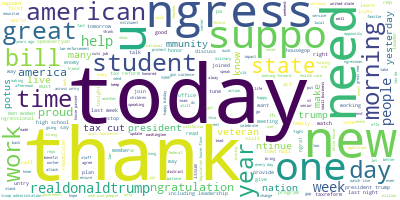

In [49]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['tokens'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [63]:
# Creating a feature for the tf-idf vectors
df['tfidf'] = (
    hero.tfidf(df['tokens'], max_features=20))

# Using the tf-idf vectors to plot a PCA graph
df['pca'] = hero.pca(df['tfidf'])
hero.scatterplot(
    df, 
    col='pca', 
    color='Handle', 
    title="Is there a Party difference?"
)

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [ ]:
# This is for if you want to try the gensim LDA models after trying sklearn version
# import gensim.corpora as corpora

# data_words = list(df['tokens'])

# # Create Dictionary
# id2word = corpora.Dictionary(data_words)

# # Create Corpus
# texts = data_words

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # View
# print(corpus[:1][0][:30])

# # number of topics
# num_topics = 10

# # Build LDA model
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=num_topics)

# Topic Modelling with Latent Dirichlet Allocation

In [59]:
corpus = df['tokens']

In [60]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)

dtm_tf = tf_vectorizer.fit_transform(corpus)
print(dtm_tf.shape)

(86460, 8225)


In [61]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(corpus)
print(dtm_tfidf.shape)

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1805: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.



(86460, 8225)


In [62]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=42)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=42)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=42)

## Visualizing the models with pyLDAvis


In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)


### Using different MDS functions


#### With sklearn installed, other MDS functions, such as MMDS and TSNE can be used for plotting if the default PCoA is not satisfactory.



In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')


In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')


In [ ]:
lda_output = lda_tf.transform(dtm_tf)
df_lda = pd.DataFrame(np.round(lda_output, 2))
df_lda

In [38]:
new_df = pd.concat([df, df_lda], axis=1).drop(columns=['tfidf', 'pca'])

### Groupby's to see Trends

In [35]:
by_party = new_df.drop(columns=['Handle', 'Tweet', 'tokens'])
by_party.groupby('Party').mean()

NameError: name 'new_df' is not defined

In [ ]:
by_member = new_df.drop(columns=['Party', 'Tweet', 'tokens'])
by_member.groupby('Handle').mean()

In [39]:
new_df.to_csv('../data/df_with_lda.csv')